# Setting up

In [112]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

input_prefix = "../input/anz_crash_20200903_fix/"
output_data = "../output/output_data.csv"

cas_fp = input_prefix + "Casualties.csv"
crash_fp = input_prefix + "Crash2.csv"
dt_fp = input_prefix + "DateTime.csv"
desc_fp = input_prefix + "Description.csv"
loc_fp = input_prefix + "Location2.csv"
veh_fp = input_prefix + "Vehicles.csv"

Crash.csv is the "central" csv file that the other csv files connect to.

Rows in crash.csv contain id values that link to description, datetime, location, casualties, and vehicles.

The dataset source is https://www.kaggle.com/datasets/mgray39/australia-new-zealand-road-crash-dataset?resource=download-directory&select=anz_crash_20200903_fix and the link contains a graphic which clearly explains how all the files link together.

In order to make this data usable, all the data needs to be combined using the id information.

# Combine all csv files together

In [113]:
cas_dat = pd.read_csv(cas_fp)
crash_dat = pd.read_csv(crash_fp)
dt_dat = pd.read_csv(dt_fp)
desc_dat = pd.read_csv(desc_fp)
loc_dat = pd.read_csv(loc_fp)
veh_dat = pd.read_csv(veh_fp)

# create new dataframe with features from datasets and crash data

data = pd.DataFrame(crash_dat)

# cross reference the feature data in crash with other datasets to build the new dataframe

try:
    data = data.merge(desc_dat[1:], on='description_id')
    data = data.merge(cas_dat[1:], on='casualties_id')
    data = data.merge(dt_dat[1:], on='date_time_id')
    data = data.merge(loc_dat[1:], on='lat_long')
    data = data.merge(veh_dat[1:], on='vehicles_id')
except KeyError as e:
    print(e)

print(desc_dat)
print(data)
print(data.info())

C:\Users\thr0w\anaconda3\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\thr0w\anaconda3\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (3,6,7,8,9,10,11,12,13,14,16) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\thr0w\anaconda3\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (5,6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\thr0w\anaconda3\envs\tf-gpu\lib\site-packages\pandas\core\frame.py:9190: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Unnamed: 0_x'} in the result is deprecated and will raise a MergeError in a future vers

         Unnamed: 0  description_id         severity speed_limit  midblock  \
0                 0               0  property_damage          60      True   
1                 1               1  property_damage          40      True   
2                 2               2  property_damage         100      True   
3                 3               3  property_damage          60     False   
4                 4               4  property_damage          60     False   
...             ...             ...              ...         ...       ...   
1519450     1519450         1519450   serious_injury         NaN      True   
1519451     1519451         1519451  property_damage         NaN     False   
1519452     1519452         1519452  property_damage         NaN     False   
1519453     1519453         1519453  property_damage         NaN      True   
1519454     1519454         1519454  property_damage         NaN      True   

         intersection road_position_horizontal road_position_ve

# Drop Useless Data

Many columns are not useful here. Features such as street name and other geoloc data is not relevant. Therefore it should be dropped. Government data is also mostly irrelevant. Drugs_alcohol is a very relevant feature, however it only has 1k entries.

In [114]:
# specify which columns should be dropped

droppers = ['crash_id', 'lat_long', 'date_time_id', 'vehicles_id', 'description_id', 'casualties_id',
           'approximate', 'latitude', 'longitude', 'country', 'state', 'local_government_area', 'statistical_area',
           'suburb', 'Unnamed: 0_y', 'Unnamed: 0_x', 'comment', 'DCA_code', 'day_of_month', 'drugs_alcohol']

for x in droppers:
    data = data.drop(x, axis=1)



# Data analysis
Here we take a quick look at what our data now consists of. We see a preview of the data and some useful information about the dataset.

In [115]:
print(data.head())
print(data.info())

       severity speed_limit  midblock  intersection road_position_horizontal  \
0  minor_injury          60     False          True                 straight   
1  minor_injury          60     False          True                 straight   
2  minor_injury          60     False          True                 straight   
3  minor_injury          60     False          True                 straight   
4  minor_injury          60     False          True                 straight   

  road_position_vertical road_sealed road_wet weather  crash_type  ...  \
0                  level        True    False    fine    Rear End  ...   
1                  level        True    False    fine    Rear End  ...   
2                  slope        True    False    fine    Rear End  ...   
3                  level        True    False    fine    Rear End  ...   
4                  level        True    False    fine  Right Turn  ...   

  truck_large  bus  taxi  bicycle  scooter  pedestrian  inanimate  train  

# Drop more columns
Now that we can see the non null counts, we can drop columns that do are not complete enough to be useful. We also want to drop casualties, fatalaties, and the injuries category as that is encompassed by severity, which is what we are trying to predict.

In [116]:
data = data.drop('road_position_horizontal', axis = 1)
data = data.drop('road_position_vertical', axis = 1)
data = data.drop('crash_type', axis = 1)
data = data.drop('traffic_controls', axis = 1)

data = data.drop('casualties', axis = 1)
data = data.drop('fatalities', axis = 1)
data = data.drop('serious_injuries', axis = 1)
data = data.drop('minor_injuries', axis = 1)

print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1421335 entries, 0 to 1421334
Data columns (total 30 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   severity           1421335 non-null  object 
 1   speed_limit        638407 non-null   object 
 2   midblock           1421335 non-null  bool   
 3   intersection       1421335 non-null  bool   
 4   road_sealed        892145 non-null   object 
 5   road_wet           892106 non-null   object 
 6   weather            1266983 non-null  object 
 7   lighting           1266983 non-null  object 
 8   year               1421335 non-null  int64  
 9   month              1227905 non-null  float64
 10  day_of_week        1227905 non-null  float64
 11  hour               1227905 non-null  float64
 12  animals            1101698 non-null  float64
 13  car_sedan          1101698 non-null  float64
 14  car_utility        1101698 non-null  float64
 15  car_van            1101698 non-n

# Drop rows with empty entries
Now that we have our feature selection shaved down, its time to drop the rows with empty data entries.

In [117]:
data = data.dropna(axis=0)
print(data.head())
print(data.info())
print(data.describe())

       severity speed_limit  midblock  intersection road_sealed road_wet  \
0  minor_injury          60     False          True        True    False   
1  minor_injury          60     False          True        True    False   
2  minor_injury          60     False          True        True    False   
3  minor_injury          60     False          True        True    False   
4  minor_injury          60     False          True        True    False   

  weather  lighting  year  month  ...  truck_large  bus  taxi  bicycle  \
0    fine  daylight  2012    1.0  ...          0.0  0.0   0.0      0.0   
1    fine  daylight  2012    1.0  ...          0.0  0.0   0.0      0.0   
2    fine  daylight  2014    2.0  ...          0.0  0.0   0.0      0.0   
3    fine  daylight  2015    2.0  ...          0.0  0.0   0.0      0.0   
4    fine  daylight  2016   10.0  ...          0.0  0.0   0.0      0.0   

   scooter  pedestrian  inanimate  train  tram  vehicle_other  
0      0.0         0.0        0.0 

# Convert alphanumeric values to numeric
We can see there are 6 object types that need to be converted, which are:
Severity,
Speed_limit,
Road_sealed,
Road_wet,
Weather,
Lighting

We need to see what are all the possible unique values in these columns

In [118]:
print(data['severity'].unique())
print(data['speed_limit'].unique())
print(data['road_sealed'].unique())
print(data['road_wet'].unique())
print(data['weather'].unique())
print(data['lighting'].unique())
#print(data['drugs_alcohol'].unique())

['minor_injury' 'serious_injury' 'fatality']
[60 70 50 25 80 90 100 110 40 '60 km/h' '80 - 90 km/h' '0 - 50 km/h'
 '100 - 110 km/h' '70 km/h' 10 15 30 20 5]
[True False]
[False True]
['fine' 'rain' 'unknown' 'smoke_dust' 'fog']
['daylight' 'darkness_not_lit' 'darkness_lit' 'dawn_dusk' 'unknown']


Using the above output, we can convert these to numeric and boolean types.

In [119]:
data['severity'].mask(data['severity'] == 'minor_injury', 0, inplace=True)
data['severity'].mask(data['severity'] == 'serious_injury', 1, inplace=True)
data['severity'].mask(data['severity'] == 'fatality', 2, inplace=True)
data['severity'] = data['severity'].astype('int64')

# for speed limit we will round up for the value range
# 0-50 is too large of a range to account for however, we will need to drop these rows
data['speed_limit'].mask(data['speed_limit'] == '60 km/h', 60, inplace=True)
data['speed_limit'].mask(data['speed_limit'] == '80 - 90 km/h', 90, inplace=True)
data['speed_limit'].mask(data['speed_limit'] == '70 km/h', 70, inplace=True)
data['speed_limit'].mask(data['speed_limit'] == '100 - 110 km/h', 110, inplace=True)
data = data[data.speed_limit.isin(['0 - 50 km/h']) == False]
data['speed_limit'] = data['speed_limit'].astype('int64')

data['road_sealed'] = data['road_sealed'].astype('bool')

data['road_wet'] = data['road_wet'].astype('bool')

data['weather'].mask(data['weather'] == 'fine', 0, inplace=True)
data['weather'].mask(data['weather'] == 'rain', 1, inplace=True)
data['weather'].mask(data['weather'] == 'unknown', 2, inplace=True)
data['weather'].mask(data['weather'] == 'smoke_dust', 3, inplace=True)
data['weather'].mask(data['weather'] == 'fog', 4, inplace=True)
data['weather'] = data['weather'].astype('int64')

data['lighting'].mask(data['lighting'] == 'daylight', 0, inplace=True)
data['lighting'].mask(data['lighting'] == 'darkness_not_lit', 1, inplace=True)
data['lighting'].mask(data['lighting'] == 'darkness_lit', 2, inplace=True)
data['lighting'].mask(data['lighting'] == 'dawn_dusk', 3, inplace=True)
data['lighting'].mask(data['lighting'] == 'unknown', 4, inplace=True)
data['lighting'] = data['lighting'].astype('int64')

#data['drugs_alcohol'].mask(data['drugs_alcohol'] == 'Y', True, inplace=True)
#data['drugs_alcohol'] = data['drugs_alcohol'].astype('bool')

# we should take this chance to convert some of the float values to int
convert = ['day_of_week', 'animals', 'car_sedan', 'car_utility', 'car_van', 'car_4x4', 'car_station_wagon',
          'motor_cycle', 'truck_small', 'truck_large', 'bus', 'taxi', 'bicycle', 'scooter', 'pedestrian',
          'inanimate', 'train', 'tram', 'vehicle_other', 'month']

for x in convert:
    data[x] = data[x].astype('int64')

data.to_csv(output_data, index=False)
print(data.info())
print(data.head())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 230188 entries, 0 to 1421327
Data columns (total 30 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   severity           230188 non-null  int64  
 1   speed_limit        230188 non-null  int64  
 2   midblock           230188 non-null  bool   
 3   intersection       230188 non-null  bool   
 4   road_sealed        230188 non-null  bool   
 5   road_wet           230188 non-null  bool   
 6   weather            230188 non-null  int64  
 7   lighting           230188 non-null  int64  
 8   year               230188 non-null  int64  
 9   month              230188 non-null  int64  
 10  day_of_week        230188 non-null  int64  
 11  hour               230188 non-null  float64
 12  animals            230188 non-null  int64  
 13  car_sedan          230188 non-null  int64  
 14  car_utility        230188 non-null  int64  
 15  car_van            230188 non-null  int64  
 16  c

# Heatmap

<AxesSubplot:>

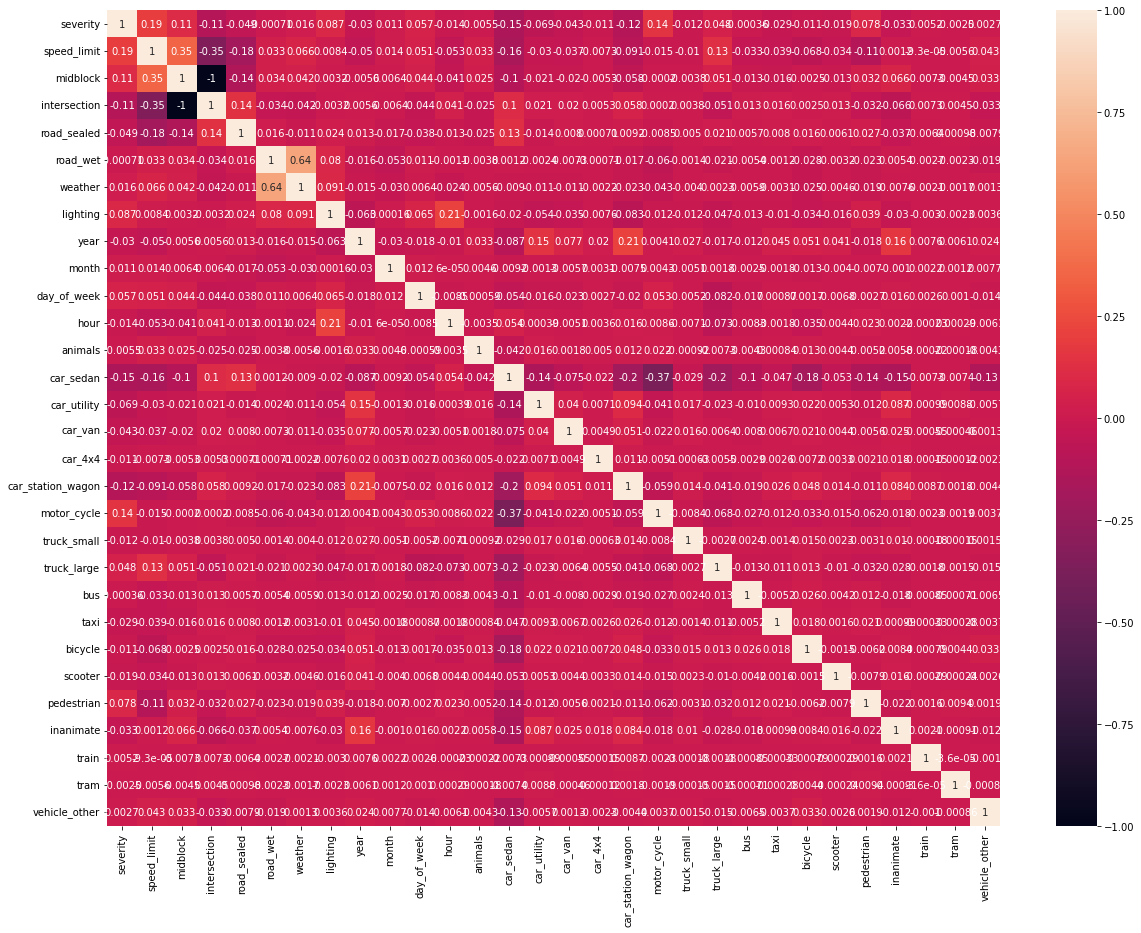

In [120]:
plt.figure(figsize=(20,15))
sns.heatmap(data.corr(), annot=True)

# Drop data based on heatmap
The heatmap shows some data has almost no correlation or too strong a correlation with other features. These features need to be dropped.

In [121]:
data = data.drop('midblock', axis=1)
data = data.drop('road_wet', axis=1)

# Data aggregation
Some data features are similar to other features.

<AxesSubplot:>

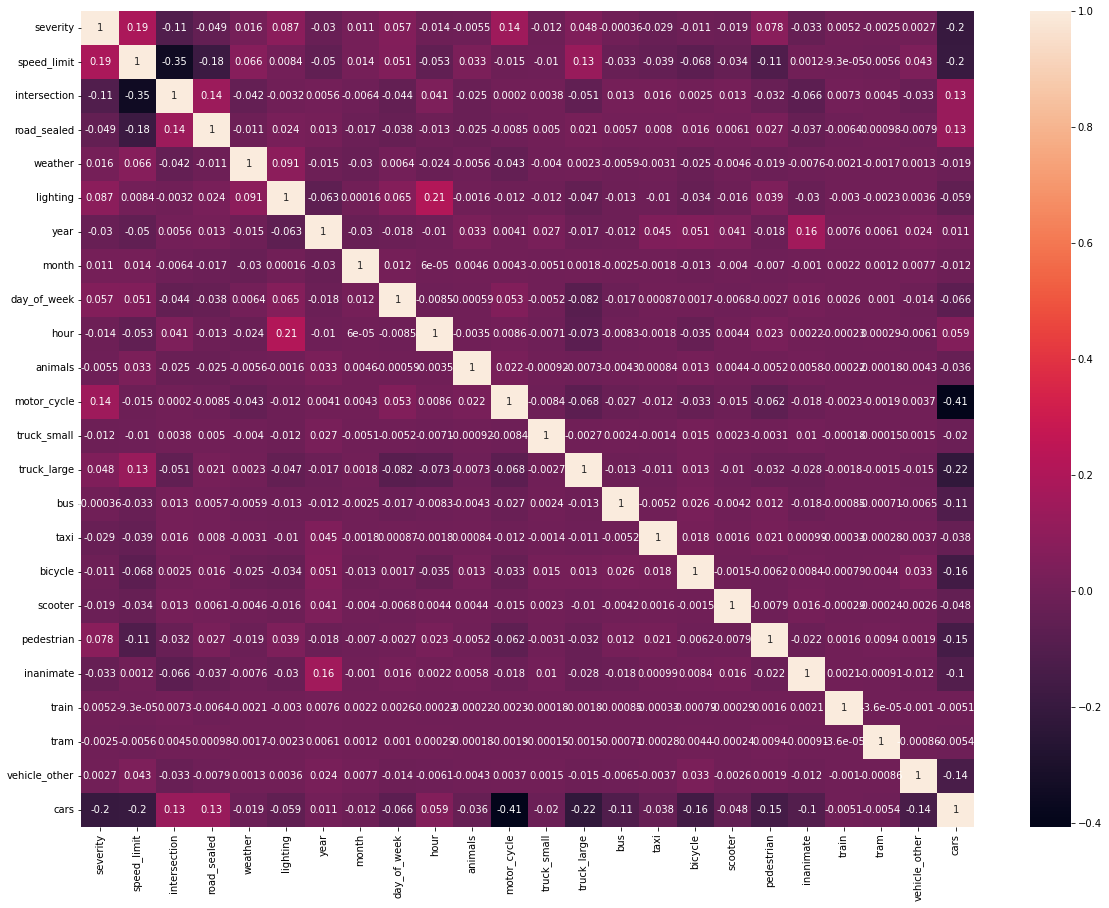

In [122]:
cars = data['car_sedan'] + data['car_utility'] + data['car_van'] + data['car_4x4'] + data['car_station_wagon']
data = data.drop('car_sedan', axis=1)
data = data.drop('car_utility', axis=1)
data = data.drop('car_van', axis=1)
data = data.drop('car_4x4', axis=1)
data = data.drop('car_station_wagon', axis=1)

data['cars'] = cars

plt.figure(figsize=(20,15))
sns.heatmap(data.corr(), annot=True)

# Random Forest
First to test is the random forest model. We will be testing if we can predict the severity of a crash based on all other data present.

In [123]:
x = (data.drop('severity', axis=1)).to_numpy()
y = data[['severity']].to_numpy().ravel()

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20)

model = RandomForestClassifier(max_depth = 7, n_estimators = 101, min_impurity_decrease=0.01, bootstrap = True)
model.fit(X_train, y_train)
print(model.score(X_test, y_test))

0.6402971458360485
